In [1]:
import numpy as np
X = np.load("pneumonia_images.npy")
y = np.load("pneumonia_labels.npy")

Visualizziamo alcune immagini del dataset, target = 1 => Polmonite, target = 0 => Negativo

In [2]:
print("Number of images:", X.shape[0])
positive = 0
negative = 0

for i in range(X.shape[0]):
    if(y[i]==1):
        positive += 1
    if(y[i]==0):
        negative += 1

print("Number of positive cases:", positive)
print("Number of negative cases:", negative)

Number of images: 5232
Number of positive cases: 3883
Number of negative cases: 1349


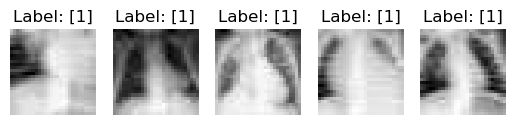

In [3]:

import matplotlib.pyplot as plt


# Visualizza alcune immagini
num_images_to_display = 5

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X))
    image = X[index]
    label = y[index]

    # Visualizza l'immagine con la sua etichetta
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Il dataset è sbilanciato verso le immagini con polmonite:

Circa il 74.2% delle immagini rappresentano casi di polmonite.
Circa il 25.8% delle immagini rappresentano casi negativi.

Andiamo a suddividere il train set tra training e test, utilizzando stratify per mantenere proporzione tra le classi

In [5]:
from sklearn.model_selection import train_test_split

# Suddivisione in set di addestramento e set di validazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A questo punto andiamo a dividere il Training Set in Training e Validation, mantenendo la stessa proporzione

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Vado a normalizzare i dati dopo aver suddiviso Training, Validation e Test per evitare Data Leakage

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_valid.reshape(X_valid.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

X_train_normalized = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_normalized = scaler.transform(X_val_reshaped).reshape(X_valid.shape)
X_test_normalized = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print(f"Normalized training set size: {X_train_normalized.shape}")
print(f"Normalized validation set size: {X_val_normalized.shape}")
print(f"Normalized test set size: {X_test_normalized.shape}")

Normalized training set size: (3348, 28, 28)
Normalized validation set size: (837, 28, 28)
Normalized test set size: (1047, 28, 28)


Essendo le classi sbilanciate, preferiamo una metrica come F1 rispetto a accuracy

In [8]:
from tensorflow.keras import backend as K

# Funzione per calcolare l'F1-score
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

Definiamo una funzione per la stampa dei vari grafici

In [9]:
import matplotlib.pyplot as plt

def graphics(history):
    plt.figure(figsize=(12, 4))

    # Plot della perdita
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle metriche
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['f1_score'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

Andiamo a eseguire il Training tramite Convolutional NN, utilizziamo una semplice CNN composta da 2 strati convoluzionali e uno strato Dense da 128 unità per la classificazione binaria, quest'ultima realizzata con un livello Dense di 1 unità con funzione di attivazione sigmoid

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [23]:
cnn1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])


In [26]:
# Stampa una rappresentazione del modello
cnn1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [28]:
# Compilazione del modello
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [30]:
history = cnn1.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_data=(X_val_normalized, y_valid))

Epoch 1/50
105/105 [==============================] - 8s 56ms/step - loss: 0.3757 - accuracy: 0.8297 - f1_score: 0.8969 - val_loss: 0.2191 - val_accuracy: 0.9104 - val_f1_score: 0.9357
Epoch 2/50
105/105 [==============================] - 5s 47ms/step - loss: 0.1635 - accuracy: 0.9385 - f1_score: 0.9579 - val_loss: 0.1703 - val_accuracy: 0.9319 - val_f1_score: 0.9517
Epoch 3/50
105/105 [==============================] - 5s 46ms/step - loss: 0.1245 - accuracy: 0.9540 - f1_score: 0.9686 - val_loss: 0.1241 - val_accuracy: 0.9486 - val_f1_score: 0.9615
Epoch 4/50
105/105 [==============================] - 5s 45ms/step - loss: 0.1131 - accuracy: 0.9546 - f1_score: 0.9687 - val_loss: 0.1198 - val_accuracy: 0.9510 - val_f1_score: 0.9622
Epoch 5/50
105/105 [==============================] - 5s 43ms/step - loss: 0.1031 - accuracy: 0.9630 - f1_score: 0.9748 - val_loss: 0.1128 - val_accuracy: 0.9618 - val_f1_score: 0.9701
Epoch 6/50
105/105 [==============================] - 5s 44ms/step - loss: 

105/105 [==============================] - 5s 44ms/step - loss: 0.0220 - accuracy: 0.9901 - f1_score: 0.9933 - val_loss: 0.1359 - val_accuracy: 0.9665 - val_f1_score: 0.9689
Epoch 46/50
105/105 [==============================] - 6s 55ms/step - loss: 0.0285 - accuracy: 0.9901 - f1_score: 0.9930 - val_loss: 0.1511 - val_accuracy: 0.9677 - val_f1_score: 0.9733
Epoch 47/50
105/105 [==============================] - 5s 50ms/step - loss: 0.0205 - accuracy: 0.9919 - f1_score: 0.9944 - val_loss: 0.1189 - val_accuracy: 0.9737 - val_f1_score: 0.9740
Epoch 48/50
105/105 [==============================] - 4s 38ms/step - loss: 0.0066 - accuracy: 0.9970 - f1_score: 0.9978 - val_loss: 0.1495 - val_accuracy: 0.9701 - val_f1_score: 0.9744
Epoch 49/50
105/105 [==============================] - 5s 47ms/step - loss: 0.0019 - accuracy: 0.9994 - f1_score: 0.9996 - val_loss: 0.1493 - val_accuracy: 0.9689 - val_f1_score: 0.9709
Epoch 50/50
105/105 [==============================] - 5s 46ms/step - loss: 8.6792

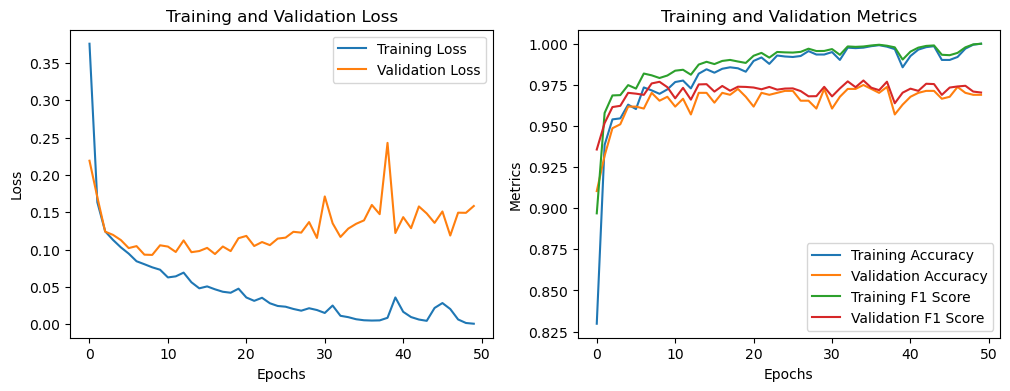

In [32]:
graphics(history)

Il modello, dalla curva riguardante la Validation Loss, mostra Overfitting, proviamo ad usare tecniche per ridurlo

Tecniche usate:
    -Dropout
    -Early Stopping

Aggiungiamo inoltre Batch Normalization.
In questo caso andiamo a stabilire dei valori base, successivamente faremo del tuning degli hyperparameters

In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


# Definizione del modello
cnn1 = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Definizione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 13, 13, 8)        32        
 chNormalization)                                                
                                                                 
 dropout_20 (Dropout)        (None, 13, 13, 8)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 32)        2336      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 32)        

In [38]:
# Addestramento del modello
history2 = cnn1.fit(X_train_normalized, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val_normalized, y_valid), 
                    callbacks=[early_stopping])

Epoch 1/50
105/105 [==============================] - 8s 43ms/step - loss: 2.8415 - accuracy: 0.7897 - f1_score: 0.8447 - val_loss: 2.5534 - val_accuracy: 0.7419 - val_f1_score: 0.8462
Epoch 2/50
105/105 [==============================] - 4s 33ms/step - loss: 1.9853 - accuracy: 0.8928 - f1_score: 0.9268 - val_loss: 2.0766 - val_accuracy: 0.7419 - val_f1_score: 0.8462
Epoch 3/50
105/105 [==============================] - 4s 39ms/step - loss: 1.4901 - accuracy: 0.9137 - f1_score: 0.9416 - val_loss: 1.8227 - val_accuracy: 0.7419 - val_f1_score: 0.8462
Epoch 4/50
105/105 [==============================] - 4s 37ms/step - loss: 1.1515 - accuracy: 0.9092 - f1_score: 0.9382 - val_loss: 1.2868 - val_accuracy: 0.7622 - val_f1_score: 0.8560
Epoch 5/50
105/105 [==============================] - 4s 39ms/step - loss: 0.8966 - accuracy: 0.9092 - f1_score: 0.9379 - val_loss: 0.8208 - val_accuracy: 0.8781 - val_f1_score: 0.9166
Epoch 6/50
105/105 [==============================] - 4s 37ms/step - loss: 

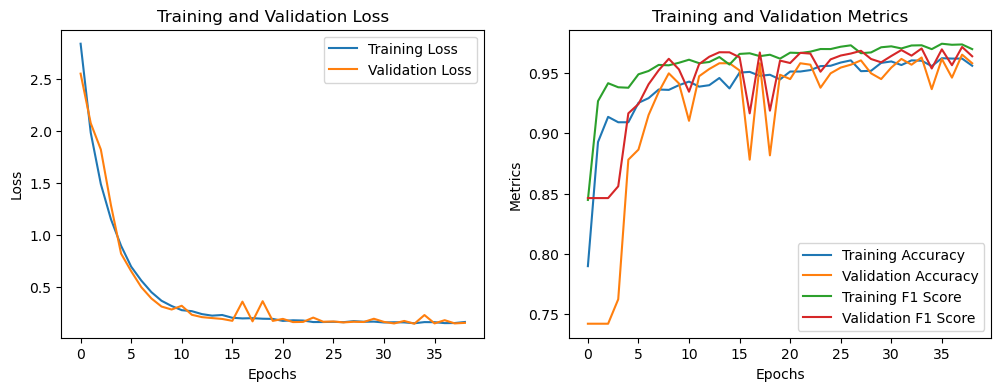

In [39]:
graphics(history2)

Abbiamo un buon miglioramento della validation loss, mentre abbiamo valori di Validation F1 Score e Validation Accuracy leggermente fluttuanti nelle varie epoche. Vediamo la Confusion Matrix:

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_val_normalized)
y_pred = np.round(y_pred_prob).astype(int)

cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

27/27 [==============================] - 0s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and unknown targets

Proviamo tuning hyperparameters

In [18]:
pip install keras-tuner --upgrade

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 640.0 kB/s eta 0:00:01
   --------- ----------------------------- 30.7/129.1 kB 640.0 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 465.5 kB/s eta 0:00:01
   ------------------ -------------------- 61.4/129.1 kB 465.5 kB/s eta 0:00:01
   ------------------------------------ - 122.9/129.1 kB 479.3 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 447.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [19]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy

class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # Layer Convoluzionali
        model.add(Conv2D(
            filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            input_shape=(28, 28, 1)
        ))
        if hp.Boolean('batch_norm_1'):
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

        model.add(Conv2D(
            filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'
        ))
        if hp.Boolean('batch_norm_2'):
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

        model.add(Conv2D(
            filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=64),
            kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
            activation='relu'
        ))
        if hp.Boolean('batch_norm_3'):
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

        model.add(Flatten())

        # Layer Densi
        model.add(Dense(
            units=hp.Int('dense_1_units', min_value=128, max_value=512, step=128),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        if hp.Boolean('batch_norm_dense_1'):
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_dense_1', min_value=0.3, max_value=0.7, step=0.1)))

        model.add(Dense(
            units=hp.Int('dense_2_units', min_value=64, max_value=256, step=64),
            activation='relu',
            kernel_regularizer=l2(0.01)
        ))
        if hp.Boolean('batch_norm_dense_2'):
            model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_dense_2', min_value=0.3, max_value=0.7, step=0.1)))

        # Output Layer
        model.add(Dense(1, activation='sigmoid'))

        # Compilazione del modello
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy',
                      metrics=['accuracy', BinaryAccuracy(name='binary_accuracy')])

        return model

class CustomRandomSearch(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['callbacks'] = [EarlyStopping(monitor='val_loss', patience=3)]
        super(CustomRandomSearch, self).run_trial(trial, *args, **kwargs)
        
        # Restituisci le metriche di valutazione
        return self.oracle.fetch_trial(trial.trial_id).metrics.get_best_value('val_accuracy')

# Definizione del tuner personalizzato
tuner = CustomRandomSearch(
    CNNHyperModel(),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Per avviare la ricerca
tuner.search(X_train_normalized, y_train, epochs=50, validation_data=(X_val_normalized, y_valid))


Trial 2 Complete [00h 00m 01s]

Best val_accuracy So Far: None
Total elapsed time: 00h 08m 13s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filter
5                 |5                 |conv_1_kernel
False             |False             |batch_norm_1
0.4               |0.2               |dropout_1
128               |96                |conv_2_filter
5                 |5                 |conv_2_kernel
True              |False             |batch_norm_2
0.3               |0.5               |dropout_2
256               |128               |conv_3_filter
3                 |3                 |conv_3_kernel
False             |False             |batch_norm_3
0.5               |0.1               |dropout_3
128               |512               |dense_1_units
False             |True              |batch_norm_dense_1
0.4               |0.5               |dropout_dense_1
128               |192               |dense_2_units
F

105/105 [==============================] - 6s 59ms/step - loss: 0.3422 - accuracy: 0.9041 - binary_accuracy: 0.9041 - val_loss: 0.3883 - val_accuracy: 0.8973 - val_binary_accuracy: 0.8973
Epoch 9/50
105/105 [==============================] - 5s 52ms/step - loss: 0.3420 - accuracy: 0.9146 - binary_accuracy: 0.9146 - val_loss: 0.7260 - val_accuracy: 0.8542 - val_binary_accuracy: 0.8542
Epoch 10/50
105/105 [==============================] - 7s 64ms/step - loss: 0.3458 - accuracy: 0.9035 - binary_accuracy: 0.9035 - val_loss: 0.5981 - val_accuracy: 0.8232 - val_binary_accuracy: 0.8232


Traceback (most recent call last):
  File "C:\Users\HP\miniconda3\envs\MachineLearning\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\HP\miniconda3\envs\MachineLearning\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\HP\AppData\Local\Temp\ipykernel_20672\326991272.py", line 80, in run_trial
    return self.oracle.fetch_trial(trial.trial_id).metrics.get_best_value('val_accuracy')
AttributeError: 'RandomSearchOracle' object has no attribute 'fetch_trial'. Did you mean: 'get_trial'?


RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\HP\miniconda3\envs\MachineLearning\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\HP\miniconda3\envs\MachineLearning\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\HP\AppData\Local\Temp\ipykernel_20672\326991272.py", line 80, in run_trial
    return self.oracle.fetch_trial(trial.trial_id).metrics.get_best_value('val_accuracy')
AttributeError: 'RandomSearchOracle' object has no attribute 'fetch_trial'. Did you mean: 'get_trial'?
